In [1]:
from keras.datasets import cifar100    
from models.utils import ResNet18, split_dataframe, detect_drifts
from skimage.transform import resize
import keras
import numpy as np
import models.unmasking_drift_detector as unm
import models.d3_drift_detector as d3
import matplotlib.pyplot as plt

2024-02-13 16:45:41.897591: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-13 16:45:41.929151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 16:45:41.929172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 16:45:41.931365: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 16:45:41.938590: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-13 16:45:41.938891: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
(images_train, labels_train), (images_test, labels_test) = cifar100.load_data()

# svhn_data = loadmat('train_32x32.mat')
# svhn_images, svhn_labels = svhn_data['X'], svhn_data['y']
# svhn_images = np.moveaxis(svhn_images, -1, 0)
# cap = svhn_images.shape[0] // 2
# idx = int(0.8 * cap)

In [3]:
images_test.shape, np.unique(labels_test)

((10000, 32, 32, 3),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]))

In [4]:
train_indices = np.where(np.isin(labels_train, range(50)))[0]
X_train = images_train[train_indices]
y_train = labels_train[train_indices]
test_indices = np.where(np.isin(labels_test, range(50)))[0]
X_test = images_test[test_indices]
y_test = labels_test[test_indices]

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 32, 32, 3), (25000, 1), (5000, 32, 32, 3), (5000, 1))

In [8]:
# model = ResNet18(input_shape=(32, 32, 3), n_classes=50)
# model.compile(optimizer=keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.fit(X_train, y_train, batch_size=64, epochs=25, validation_data=(X_test, y_test))
# # Epoch 25/25
# # 391/391 [==============================] - 368s 941ms/step - loss: 0.1130 - accuracy: 0.9637 - val_loss: 3.8596 - val_accuracy: 0.4540

Epoch 1/25
391/391 [==============================] - 368s 931ms/step - loss: 3.1643 - accuracy: 0.2005 - val_loss: 5.8547 - val_accuracy: 0.1230
Epoch 2/25
391/391 [==============================] - 352s 901ms/step - loss: 2.4913 - accuracy: 0.3368 - val_loss: 3.6828 - val_accuracy: 0.2090
Epoch 3/25
391/391 [==============================] - 357s 912ms/step - loss: 2.1019 - accuracy: 0.4230 - val_loss: 4.7433 - val_accuracy: 0.1804
Epoch 4/25
391/391 [==============================] - 360s 922ms/step - loss: 1.8452 - accuracy: 0.4838 - val_loss: 2.8407 - val_accuracy: 0.3200
Epoch 5/25
391/391 [==============================] - 361s 924ms/step - loss: 1.5988 - accuracy: 0.5409 - val_loss: 2.8185 - val_accuracy: 0.3276
Epoch 6/25
391/391 [==============================] - 357s 914ms/step - loss: 1.3960 - accuracy: 0.5884 - val_loss: 2.7143 - val_accuracy: 0.3696
Epoch 7/25
391/391 [==============================] - 374s 957ms/step - loss: 1.1705 - accuracy: 0.6511 - val_loss: 2.5057 -

In [6]:
import tensorflow as tf
# model.save('model_25epochs.h5')
model = tf.keras.models.load_model('driftDatasets/model_25epochs.h5')


In [7]:
extract_features_model = keras.Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)

In [8]:
unseen_data_indices = np.where(np.isin(labels_train, range(50, 100)))[0]
unseen_data = images_train[unseen_data_indices]
unseen_data.shape

(25000, 32, 32, 3)

In [9]:
from keras.datasets import mnist
(mnist_images, _), (_, _) = mnist.load_data()
mnist_images = resize(mnist_images, (mnist_images.shape[0],32,32,3))

In [10]:
drifted_data = np.empty((0, 32, 32, 3))
i = 0
last_index = 0
current_index = 0
ground_truth_drifts = []

dimension_limit = 0.8 * X_train.shape[0]
while drifted_data.shape[0] < dimension_limit:
    current_index += np.random.choice([200, 400, 600, 800])
    if i % 2 == 0:
        if i != 0:
            ground_truth_drifts.append(drifted_data.shape[0])
        known_batch = X_train[3*last_index:3*current_index]
        drifted_data = np.concatenate((drifted_data, known_batch), axis=0)
    else:
        # ground_truth_drifts.append(drifted_data.shape[0])
        known_batch = X_train[2*last_index:2*current_index]
        batch = np.concatenate((known_batch, mnist_images[last_index:current_index]), axis=0)
        np.random.shuffle(batch)
        drifted_data = np.concatenate((drifted_data, batch), axis=0)
    last_index = current_index
    i += 1

In [11]:
# drifted_data = np.empty((0, 32, 32, 3))
# i = 0
# last_index = 0
# current_index = 0
# ground_truth_drifts = []

# dimension_limit = 0.9 * images_train.shape[0]
# while drifted_data.shape[0] < dimension_limit:
#     if i % 2 == 0:
#         current_index += np.random.choice([400, 800, 1200, 1600])
#         if i != 0:
#             ground_truth_drifts.append(drifted_data.shape[0])
#         known_batch = X_train[last_index:current_index]
#         drifted_data = np.concatenate((drifted_data, known_batch), axis=0)
#     else:
#         # ground_truth_drifts.append(drifted_data.shape[0])
#         batch = unseen_data[last_index:current_index]
#         np.random.shuffle(batch)
#         drifted_data = np.concatenate((drifted_data, batch), axis=0)
#         last_index = current_index
#     i += 1

In [12]:
drifted_data.shape

(21000, 32, 32, 3)

In [13]:
features = extract_features_model.predict(drifted_data)
features.shape

2024-02-13 16:46:40.598245: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 258048000 exceeds 10% of free system memory.


657/657 [==============================] - 10s 15ms/step


2024-02-13 16:46:50.882675: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 43008000 exceeds 10% of free system memory.


(21000, 512)

In [14]:
batch_size = 400
data_splitted = split_dataframe(features, batch_size)
ground_truth_drifts_batch = np.array(ground_truth_drifts) / 400
ground_truth_drifts_batch = ground_truth_drifts_batch.astype(int)
ground_truth_drifts_batch

array([ 6, 13, 16, 21, 30, 37, 43])

In [15]:
# np.save("ground_truth_drifts_batch_cifar.npy", ground_truth_drifts_batch)
# np.save("features_cifar.npy", features)

Unmasking:
Threshold = 0.45
0.18421052631578946
Threshold = 0.47
0.2
Threshold = 0.5
0.25925925925925924
Threshold = 0.52
0.4375
Threshold = 0.53
0.375
Threshold = 0.54
0.5454545454545454
Threshold = 0.55
0.7777777777777778
Threshold = 0.56
0.5555555555555556
Threshold = 0.57
0.25
Threshold = 0.58
0.2857142857142857
Threshold = 0.6
0.14285714285714285


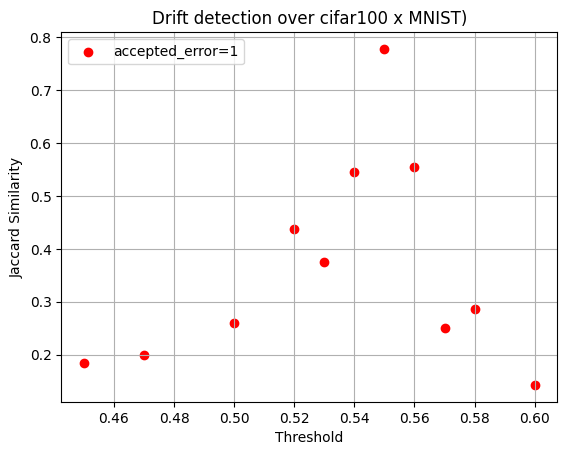

In [16]:
# Perform grid search over the unmasking algorithm.
thresholds = [0.45, 0.47, 0.5, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.6]
jaccard_sim_unm = []

print("Unmasking:")
for thr in thresholds:
    print(f"Threshold = {thr}")
    sim_unm = detect_drifts(data_splitted, unm.drift_detector, ground_truth_drifts_batch, show_drifts=False, accepted_error=1, threshold=thr, min_feature_percentage_remaining=0.05)
    print(sim_unm)
    jaccard_sim_unm.append(sim_unm)


# Plot the results
plt.xlabel('Threshold')
plt.ylabel('Jaccard Similarity')
plt.title('Drift detection over cifar100 x MNIST)')

plt.scatter(thresholds, jaccard_sim_unm, marker='o', color='red', label='accepted_error=1')
plt.grid()
plt.legend()
# plt.savefig('/images/svhn_itself_jaccard_thresholds_error1.png')
plt.show()

In [18]:
print("D3:")
sim_d3 = detect_drifts(data_splitted, d3.drift_detector, ground_truth_drifts_batch, accepted_error=1, show_drifts=False)
print(sim_d3)

D3:
0.42857142857142855
